### Cell 1

In [1]:
# Cell 1 – Install required libraries (run once, then you can comment this cell)

# If using Anaconda, many are preinstalled, but we include for completeness.
# Remove the "!" if you run this in plain Python, not Jupyter.

#!pip install -U pip
!pip install pandas numpy matplotlib scikit-learn
!pip install h2o
!pip install featuretools

   ---------------------------------------- 0.0/266.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/266.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/266.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/266.0 MB 1.8 MB/s eta 0:02:30
   ---------------------------------------- 2.4/266.0 MB 4.2 MB/s eta 0:01:03
    --------------------------------------- 4.2/266.0 MB 5.4 MB/s eta 0:00:49
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    --------------------------------------- 5.2/266.0 MB 6.1 MB/s eta 0:00:43
    ---

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Kanta\\AppData\\Local\\Temp\\pip-unpack-y14skq_p\\h2o-3.46.0.8-py2.py3-none-any.whl'
Consider using the `--user` option or check the permissions.



   ---------------------------------------- 0.0/587.9 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.9 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.9 kB ? eta -:--:--
   ---------------------------------------- 587.9/587.9 kB 745.5 kB/s  0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.3 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.3 MB 1.0 MB/s eta 0:00:01
   ------------------------ --------------- 0.8/1.3 MB 1.4 MB/s eta 0:00:01
   -------------------------------- ------- 1.0/1.3 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 1.4 MB/s  0:00:01

   ---------------------------------------- 0/5 [importlib-resources]
   ---------------------------------------- 0/5 [importl

### Cell 2

In [3]:
# Cell 2 – Imports and version info

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import h2o
from h2o.automl import H2OAutoML

import featuretools as ft

from pprint import pprint

print("pandas:", pd.__version__)
print("numpy :", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("featuretools:", ft.__version__)

C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\woodwork\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


pandas: 2.3.3
numpy : 1.26.4
matplotlib: 3.10.7
featuretools: 1.31.0


### Cell 3

In [4]:
# Cell 3 – Load dataset

CSV_PATH = "california_housing.csv"  # change if your file name is different

df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (20640, 9)
Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Price']


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Cell 4

In [5]:
# Cell 4 – Quick look at target (Price)

target_col = "Price"

print("Target column:", target_col)
print(df[target_col].describe())

# Features (original)
original_features = [c for c in df.columns if c != target_col]
print("\nOriginal feature columns:")
pprint(original_features)

Target column: Price
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: Price, dtype: float64

Original feature columns:
['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']


### Cell 5

In [6]:
# Cell 5 – Manual feature engineering function

def add_manual_features(df, target_col="Price"):
    """
    Create domain-specific features for California housing.
    Returns a NEW DataFrame with original + manual features + target.
    """
    df = df.copy()
    
    # Location-based features
    df['is_northern_ca'] = (df['Latitude'] > 37.5).astype(int)
    df['is_coastal'] = (df['Longitude'] < -118).astype(int)

    # Distances to SF and LA (rough)
    df['dist_to_sf'] = np.sqrt((df['Latitude'] - 37.77)**2 + (df['Longitude'] - (-122.42))**2)
    df['dist_to_la'] = np.sqrt((df['Latitude'] - 34.05)**2 + (df['Longitude'] - (-118.24))**2)

    # Household composition
    df['rooms_per_household'] = df['AveRooms'] / (df['AveOccup'] + 1e-3)
    df['bedrooms_per_room'] = df['AveBedrms'] / (df['AveRooms'] + 1e-3)
    df['people_per_room'] = df['AveOccup'] / (df['AveRooms'] + 1e-3)

    # Income ratios
    df['income_per_room'] = df['MedInc'] / (df['AveRooms'] + 1e-3)
    df['income_per_person'] = df['MedInc'] / (df['AveOccup'] + 1e-3)

    # Non-linear transformations
    df['medinc_squared'] = df['MedInc'] ** 2
    df['medinc_log'] = np.log1p(df['MedInc'])
    df['rooms_log'] = np.log1p(df['AveRooms'])

    # Interactions
    df['income_rooms_interaction'] = df['MedInc'] * df['AveRooms']
    df['income_age_interaction'] = df['MedInc'] * df['HouseAge']
    df['coastal_income_interaction'] = df['is_coastal'] * df['MedInc']

    return df

### Cell 6

In [7]:
# Cell 6 – Create original + manual features

df_manual = add_manual_features(df, target_col=target_col)

print("Original columns:", len(df.columns))
print("After manual FE  :", len(df_manual.columns))
print("New manual feature columns:")
new_cols_manual = [c for c in df_manual.columns if c not in df.columns or c == target_col]
pprint([c for c in df_manual.columns if c not in df.columns])

df_manual.head()

Original columns: 9
After manual FE  : 24
New manual feature columns:
['is_northern_ca',
 'is_coastal',
 'dist_to_sf',
 'dist_to_la',
 'rooms_per_household',
 'bedrooms_per_room',
 'people_per_room',
 'income_per_room',
 'income_per_person',
 'medinc_squared',
 'medinc_log',
 'rooms_log',
 'income_rooms_interaction',
 'income_age_interaction',
 'coastal_income_interaction']


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price,is_northern_ca,...,bedrooms_per_room,people_per_room,income_per_room,income_per_person,medinc_squared,medinc_log,rooms_log,income_rooms_interaction,income_age_interaction,coastal_income_interaction
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1,...,0.146570,0.365857,1.191847,3.256413,69.308955,2.232720,2.077455,58.144254,341.3332,8.3252
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1,...,0.155772,0.338162,1.330537,3.932744,68.913242,2.230165,1.979364,51.785271,174.3294,8.3014
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1,...,0.129500,0.338064,0.875532,2.588914,52.669855,2.111110,2.228738,60.150315,377.3848,7.2574
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1,...,0.184427,0.437915,0.969880,2.213896,31.844578,1.893579,1.919471,32.827897,293.4412,5.6431
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1,...,0.172068,0.347210,0.612174,1.762317,14.793254,1.578195,1.985385,24.161264,200.0024,3.8462


### Cell 7

In [8]:
# Cell 7 – Automated feature engineering with Featuretools (DFS)

# Use only predictors for DFS (no Price)
X = df.drop(columns=[target_col]).copy()

# Featuretools needs an index column
X_ft = X.copy()
X_ft['row_id'] = np.arange(len(X_ft))

es = ft.EntitySet(id="housing")
es = es.add_dataframe(
    dataframe_name="houses",
    dataframe=X_ft,
    index="row_id"
)

# Simple DFS with transform primitives
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="houses",
    trans_primitives=["add_numeric", "multiply_numeric", "divide_numeric", "cum_sum"],
    max_depth=2
)

print("Feature matrix shape (including original columns):", feature_matrix.shape)
feature_matrix.head()

C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:169: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


Feature matrix shape (including original columns): (20640, 128)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,AveBedrms + AveOccup,AveBedrms + AveRooms,...,HouseAge * Latitude,HouseAge * Longitude,HouseAge * MedInc,HouseAge * Population,Latitude * Longitude,Latitude * MedInc,Latitude * Population,Longitude * MedInc,Longitude * Population,MedInc * Population
row_id,,,,,,,,,,,,,,,,,,,,,
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,3.579365,8.007937,...,1553.08,-5011.43,341.3332,13202.0,-4630.0724,315.358576,12197.36,-1017.589196,-39358.06,2680.7144
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.081722,7.210018,...,795.06,-2566.62,174.3294,50421.0,-4627.2492,314.291004,90901.86,-1014.597108,-293450.22,19931.6614
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.875706,9.361582,...,1968.20,-6356.48,377.3848,25792.0,-4626.7840,274.692590,18773.60,-887.144576,-60631.04,3599.6704
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.621005,6.890411,...,1968.20,-6357.00,293.4412,29016.0,-4627.1625,213.591335,21120.30,-689.868975,-68215.50,3148.8498
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.262548,7.362934,...,1968.20,-6357.00,200.0024,29380.0,-4627.1625,145.578670,21385.25,-470.197950,-69071.25,2173.1030


### Cell 8

In [9]:
# Cell 8 – Select top Featuretools features by correlation with Price (FIXED)

# Columns that we used as original predictors + index
original_plus_index = list(X_ft.columns)  # ['MedInc', ..., 'Longitude', 'row_id']

# Only drop the ones that really exist in feature_matrix
cols_to_drop = [c for c in original_plus_index if c in feature_matrix.columns]

print("Original+index columns present in feature_matrix and will be dropped:")
print(cols_to_drop)

# Keep only auto-generated FT features
ft_only = feature_matrix.drop(columns=cols_to_drop)

print("Number of auto-generated FT features:", ft_only.shape[1])
print("Example FT-only columns:", list(ft_only.columns[:10]))

# Align target with feature matrix index
y = df[target_col].copy()
y.index = feature_matrix.index  # just to be safe

# Compute absolute correlation with Price and select top-k
correlations = {}
for col in ft_only.columns:
    if pd.api.types.is_numeric_dtype(ft_only[col]):
        try:
            corr = abs(np.corrcoef(ft_only[col].values, y.values)[0, 1])
        except Exception:
            corr = np.nan
        if not np.isnan(corr):
            correlations[col] = corr

# Sort by correlation
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

TOP_K = 30  # you can adjust
top_ft_cols = [name for name, _ in sorted_corr[:TOP_K]]

print(f"\nSelected top {len(top_ft_cols)} Featuretools features by |corr(Price)|:")
for name, corr in sorted_corr[:min(TOP_K, 10)]:
    print(f"  {name}: {corr:.4f}")

# Build FT feature DataFrame with selected features
ft_selected = ft_only[top_ft_cols].copy()

# Prefix for clarity
ft_selected = ft_selected.add_prefix("ft_")

ft_selected.head()


Original+index columns present in feature_matrix and will be dropped:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Number of auto-generated FT features: 120
Example FT-only columns: ['AveBedrms + AveOccup', 'AveBedrms + AveRooms', 'AveBedrms + HouseAge', 'AveBedrms + Latitude', 'AveBedrms + Longitude', 'AveBedrms + MedInc', 'AveBedrms + Population', 'AveOccup + AveRooms', 'AveOccup + HouseAge', 'AveOccup + Latitude']

Selected top 30 Featuretools features by |corr(Price)|:
  MedInc / AveOccup: 0.7456
  MedInc / Latitude: 0.6898
  Longitude * MedInc: 0.6894
  MedInc / Longitude: 0.6858
  Latitude * MedInc: 0.6747
  AveBedrms + MedInc: 0.6661
  MedInc / AveRooms: 0.6653
  MedInc / AveBedrms: 0.6615
  HouseAge * MedInc: 0.5891
  AveRooms * MedInc: 0.5554


,ft_MedInc / AveOccup,ft_MedInc / Latitude,ft_Longitude * MedInc,ft_MedInc / Longitude,ft_Latitude * MedInc,ft_AveBedrms + MedInc,ft_MedInc / AveRooms,ft_MedInc / AveBedrms,ft_HouseAge * MedInc,ft_AveRooms * MedInc,...,ft_HouseAge / MedInc,ft_Population / MedInc,ft_MedInc * Population,ft_Longitude / AveOccup,ft_AveBedrms / AveRooms,ft_HouseAge / AveOccup,ft_Latitude / AveRooms,ft_Latitude / AveOccup,ft_Longitude / AveRooms,ft_HouseAge + MedInc
row_id,,,,,,,,,,,,,,,,,,,,,
0,3.257687,0.219778,-1017.589196,-0.068111,315.358576,9.349010,1.192017,8.131591,341.3332,58.144254,...,4.924807,38.677749,2680.7144,-47.829130,0.146591,16.043478,5.423727,14.822609,-17.501114,49.3252
1,3.934608,0.219266,-1014.597108,-0.067922,314.291004,9.273280,1.330750,8.541585,174.3294,51.785271,...,2.529694,289.228323,19931.6614,-57.928513,0.155797,9.953353,6.069120,17.944473,-19.592388,29.3014
2,2.589838,0.191741,-887.144576,-0.059370,274.692590,8.330846,0.875637,6.760841,377.3848,60.150315,...,7.165100,68.344035,3599.6704,-43.621935,0.129516,18.556452,4.566769,13.506956,-14.748793,59.2574
3,2.214765,0.149091,-689.868975,-0.046160,213.591335,6.716159,0.970046,5.258889,293.4412,32.827897,...,9.214793,98.881820,3148.8498,-47.979839,0.184458,20.408602,6.506397,14.855108,-21.014717,57.6431
4,1.763125,0.101617,-470.197950,-0.031462,145.578670,4.927281,0.612272,3.557735,200.0024,24.161264,...,13.519838,146.898237,2173.1030,-56.040265,0.172096,23.837168,6.025292,17.350708,-19.460817,55.8462


### Cell 9

In [10]:
# Cell 9 – Build three datasets for comparison:
# 1) Original + AutoML features
# 2) Original + Manual features
# 3) Original + Featuretools features

# 1) Original + AutoML features (no extra FE, just original columns)
df_original_autoML = df.copy()  # original features + Price

# 2) Original + Manual features
df_original_manual = df_manual.copy()  # original + manual + Price

# 3) Original + Featuretools features
X_base = df.drop(columns=[target_col]).copy()
df_original_ft = pd.concat(
    [X_base.reset_index(drop=True), ft_selected.reset_index(drop=True)],
    axis=1
)
df_original_ft[target_col] = y.values

print("Shapes:")
print("Original + AutoML features     :", df_original_autoML.shape)
print("Original + Manual features     :", df_original_manual.shape)
print("Original + Featuretools features:", df_original_ft.shape)

df_original_ft.head()


Shapes:
Original + AutoML features     : (20640, 9)
Original + Manual features     : (20640, 24)
Original + Featuretools features: (20640, 39)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,ft_MedInc / AveOccup,ft_MedInc / Latitude,...,ft_Population / MedInc,ft_MedInc * Population,ft_Longitude / AveOccup,ft_AveBedrms / AveRooms,ft_HouseAge / AveOccup,ft_Latitude / AveRooms,ft_Latitude / AveOccup,ft_Longitude / AveRooms,ft_HouseAge + MedInc,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,3.257687,0.219778,...,38.677749,2680.7144,-47.829130,0.146591,16.043478,5.423727,14.822609,-17.501114,49.3252,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.934608,0.219266,...,289.228323,19931.6614,-57.928513,0.155797,9.953353,6.069120,17.944473,-19.592388,29.3014,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,2.589838,0.191741,...,68.344035,3599.6704,-43.621935,0.129516,18.556452,4.566769,13.506956,-14.748793,59.2574,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,2.214765,0.149091,...,98.881820,3148.8498,-47.979839,0.184458,20.408602,6.506397,14.855108,-21.014717,57.6431,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,1.763125,0.101617,...,146.898237,2173.1030,-56.040265,0.172096,23.837168,6.025292,17.350708,-19.460817,55.8462,3.422


### Cell 10

In [11]:
# Cell 10 – Initialize H2O and create train/test splits for the 3 setups

h2o.init()

def to_h2o_and_split(df, target_col="Price", test_ratio=0.2, seed=42):
    hf = h2o.H2OFrame(df)
    train, test = hf.split_frame(ratios=[1 - test_ratio], seed=seed)
    return train, test

# 1) Original + AutoML features
train_orig_autoML, test_orig_autoML = to_h2o_and_split(df_original_autoML, target_col=target_col)

# 2) Original + Manual features
train_orig_manual, test_orig_manual = to_h2o_and_split(df_original_manual, target_col=target_col)

# 3) Original + Featuretools features
train_orig_ft, test_orig_ft = to_h2o_and_split(df_original_ft, target_col=target_col)

print("Original + AutoML features      – Train:", train_orig_autoML.shape, "Test:", test_orig_autoML.shape)
print("Original + Manual features      – Train:", train_orig_manual.shape, "Test:", test_orig_manual.shape)
print("Original + Featuretools features – Train:", train_orig_ft.shape, "Test:", test_orig_ft.shape)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)
  Starting server from C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Kanta\AppData\Local\Temp\tmpa8grllk0
  JVM stdout: C:\Users\Kanta\AppData\Local\Temp\tmpa8grllk0\h2o_Kanta_started_from_python.out
  JVM stderr: C:\Users\Kanta\AppData\Local\Temp\tmpa8grllk0\h2o_Kanta_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.8
H2O_cluster_version_age:,543 years and 19 days
H2O_cluster_name:,H2O_from_python_Kanta_wzhntf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.855 Gb
H2O_cluster_total_cores:,22
H2O_cluster_allowed_cores:,22
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Original + AutoML features      – Train: (16582, 9) Test: (4058, 9)
Original + Manual features      – Train: (16582, 24) Test: (4058, 24)
Original + Featuretools features – Train: (16582, 39) Test: (4058, 39)


### Cell 11

In [12]:
# Cell 11 – Helper function: run AutoML and compute metrics

def run_automl_and_evaluate(train, test, target_col="Price",
                            max_runtime_secs=60, approach_name=""):
    features = [c for c in train.columns if c != target_col]

    aml = H2OAutoML(
        max_runtime_secs=max_runtime_secs,
        seed=42,
        nfolds=5,
        exclude_algos=["DeepLearning"],  # optional, to speed up
        verbosity="warn"
    )

    print(f"\n🏃 Running AutoML for {approach_name} ...")
    aml.train(x=features, y=target_col, training_frame=train)

    best_model = aml.leader
    print(f"Best model type for {approach_name}: {type(best_model).__name__}")

    # Predictions
    preds = best_model.predict(test)
    
    # Convert to numpy
    y_true = test[target_col].as_data_frame().values.flatten()
    y_pred = preds.as_data_frame().values.flatten()

    # Metrics
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0.0

    # MAPE & within 10%
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    within_10 = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8)) <= 0.10) * 100

    result = {
        "approach": approach_name,
        "model_type": type(best_model).__name__,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "mape": mape,
        "accuracy_(1-MAPE%)": 100 - mape,
        "within_10_pct": within_10
    }

    pprint(result)
    return result


### Cell 12

In [13]:
# Cell 12 – Run AutoML for the three assignment approaches

results = []

# 1) Original + AutoML features
res_orig_autoML = run_automl_and_evaluate(
    train_orig_autoML, test_orig_autoML,
    target_col=target_col,
    max_runtime_secs=60,
    approach_name="Original + AutoML features"
)
results.append(res_orig_autoML)

# 2) Original + Manual features
res_orig_manual = run_automl_and_evaluate(
    train_orig_manual, test_orig_manual,
    target_col=target_col,
    max_runtime_secs=60,
    approach_name="Original + Manual features"
)
results.append(res_orig_manual)

# 3) Original + Featuretools features
res_orig_ft = run_automl_and_evaluate(
    train_orig_ft, test_orig_ft,
    target_col=target_col,
    max_runtime_secs=60,
    approach_name="Original + Featuretools features"
)
results.append(res_orig_ft)

results



🏃 Running AutoML for Original + AutoML features ...
AutoML progress: |
17:28:48.92: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Best model type for Original + AutoML features: H2OStackedEnsembleEstimator
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
{'accuracy_(1-MAPE%)': 85.00897216097778,
 'approach': 'Original + AutoML features',
 'mae': 0.279072704971111,
 'mape': 14.991027839022223,
 'model_type': 'H2OStackedEnsembleEstimator',
 'r2': 0.8604926666787316,
 'rmse': 0.42919949176658373,
 'within_10_pct': 48.693937900443565}

🏃 Running AutoML for Original + Manual features ...
AutoML progress: |

C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



17:29:49.423: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Best model type for Original + Manual features: H2OStackedEnsembleEstimator
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
{'accuracy_(1-MAPE%)': 84.91008272505114,
 'approach': 'Original + Manual features',
 'mae': 0.27911745344168687,
 'mape': 15.089917274948855,
 'model_type': 'H2OStackedEnsembleEstimator',
 'r2': 0.8582874353493845,
 'rmse': 0.43257842920997064,
 'within_10_pct': 48.34894036471168}

🏃 Running AutoML for Original + Featuretools features ...
AutoML progress: |

C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



17:30:51.774: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Best model type for Original + Featuretools features: H2OStackedEnsembleEstimator
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
{'accuracy_(1-MAPE%)': 84.9961117707671,
 'approach': 'Original + Featuretools features',
 'mae': 0.28022858760093217,
 'mape': 15.003888229232901,
 'model_type': 'H2OStackedEnsembleEstimator',
 'r2': 0.8566524806205529,
 'rmse': 0.43506662754828596,
 'within_10_pct': 48.620009857072446}


C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\Kanta\AppData\Local\Programs\Python\Python311\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


[{'approach': 'Original + AutoML features',
  'model_type': 'H2OStackedEnsembleEstimator',
  'rmse': 0.42919949176658373,
  'mae': 0.279072704971111,
  'r2': 0.8604926666787316,
  'mape': 14.991027839022223,
  'accuracy_(1-MAPE%)': 85.00897216097778,
  'within_10_pct': 48.693937900443565},
 {'approach': 'Original + Manual features',
  'model_type': 'H2OStackedEnsembleEstimator',
  'rmse': 0.43257842920997064,
  'mae': 0.27911745344168687,
  'r2': 0.8582874353493845,
  'mape': 15.089917274948855,
  'accuracy_(1-MAPE%)': 84.91008272505114,
  'within_10_pct': 48.34894036471168},
 {'approach': 'Original + Featuretools features',
  'model_type': 'H2OStackedEnsembleEstimator',
  'rmse': 0.43506662754828596,
  'mae': 0.28022858760093217,
  'r2': 0.8566524806205529,
  'mape': 15.003888229232901,
  'accuracy_(1-MAPE%)': 84.9961117707671,
  'within_10_pct': 48.620009857072446}]

### Cell 13

In [14]:
# Cell 13 – Compare results in a table for report

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="rmse")  # best (lowest RMSE) at top

results_df

,approach,model_type,rmse,mae,r2,mape,accuracy_(1-MAPE%),within_10_pct
0,Original + AutoML features,H2OStackedEnsembleEstimator,0.429199,0.279073,0.860493,14.991028,85.008972,48.693938
1,Original + Manual features,H2OStackedEnsembleEstimator,0.432578,0.279117,0.858287,15.089917,84.910083,48.348940
2,Original + Featuretools features,H2OStackedEnsembleEstimator,0.435067,0.280229,0.856652,15.003888,84.996112,48.620010


### Cell 14

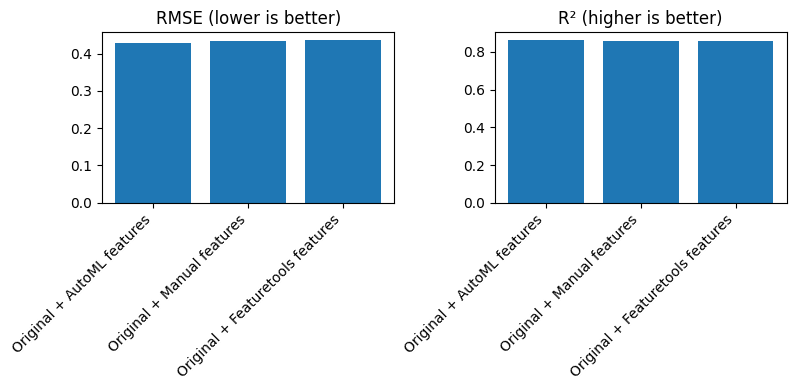

In [15]:
# Cell 14 – Plot RMSE and R² for each approach

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(results_df["approach"], results_df["rmse"])
plt.xticks(rotation=45, ha="right")
plt.title("RMSE (lower is better)")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar(results_df["approach"], results_df["r2"])
plt.xticks(rotation=45, ha="right")
plt.title("R² (higher is better)")
plt.tight_layout()

plt.show()

### Cell 15

In [16]:
# Cell 15 – Shutdown H2O cluster when done

h2o.shutdown(prompt=False)

H2O session _sid_99eb closed.


C:\Users\Kanta\AppData\Local\Temp\ipykernel_20756\2395337941.py:3: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


### Save

In [18]:
# Cell 17 – Save experiment results table to CSV and Excel

import os

results_dir = "experiment_results"
os.makedirs(results_dir, exist_ok=True)

csv_path = os.path.join(results_dir, "AutoML_Feature_Comparison.csv")
# excel_path = os.path.join(results_dir, "AutoML_Feature_Comparison.xlsx")

results_df.to_csv(csv_path, index=False)
# results_df.to_excel(excel_path, index=False)

print(f"✅ Results exported to:")
print(f"   • {csv_path}")
# print(f"   • {excel_path}")


✅ Results exported to:
   • experiment_results\AutoML_Feature_Comparison.csv
